# Data Exploration 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print(sys.version)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch

3.10.9 (main, Dec 19 2022, 17:35:49) [GCC 12.2.0]


In [53]:
sys.path.extend(["./SERVER/deployment/", "./SERVER/"])

In [67]:
from networks import LinearNetwork, VAENetwork, SACModel

### Load checkpoints 

In [68]:
DATA_ROOT = Path('./SERVER/checkpoints/')

In [69]:
checkpoints = sorted(DATA_ROOT.glob("*.pth"))
print(len(checkpoints))

113


### Load models 

In [70]:
from server import embedder_params, decision_params, translator_params

In [83]:
embedder_network = VAENetwork(embedder_params, live_train=False)
embedder_network.model.eval()
translator = SACModel(**translator_params);

debug: xxxxxxxx 140081492888304


In [84]:
data = torch.load('./SERVER/checkpoints/20230322_152848.pth')
translator.load(data["sac"])
embedder_network.model.load_state_dict(data["embedder"])

if "buffer" in data:
    translator.training_data.from_dict(data["buffer"])

### Create Data

In [85]:
FEATURE_VECTOR_MAP = [
    "EEG:mean",
    "EEG:delta",
    "EOG:all_rate",
    "EOG:p_rate",
    "EOG:n_rate",
    "GSR:mean",
    "GSR:delta",
    "heart:std",
]

OUTPUT_VECTOR = [
    "ampl",
    "freq",
    "durn",
    "idly",
    "temp1",
    "temp2",
]

OUTPUT_VECTOR_RANGES = {
    "ampl": [3, 6],
    "freq": [1, 100],
    "durn": [0, 2000],
    "idly": [0, 255],
    "temp1": [-2, 2],
    "temp2": [-2, 2],
}

### Interaction 

In [86]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [87]:
sliders = dict()
for feature in FEATURE_VECTOR_MAP:
    slider = widgets.FloatSlider(
        min=0.0, max=1.0, step=0.01, description=feature
    )
    sliders[feature] = slider

btn = widgets.Button(description="go!")
output = widgets.Output()

In [88]:
@btn.on_click
def go(b):
    step()

In [101]:
def step():
    x = torch.tensor([sliders[s].value for s in FEATURE_VECTOR_MAP])
    
    with torch.no_grad():
        z = embedder_network.model.encode(x).numpy()
    
    output.clear_output()
    with output:
        plt.scatter(z[0], z[1])
        plt.ylim(-0.5, 0.5)
        plt.xlim(-0.1, 0.1)
        plt.show()

In [102]:
for feature in FEATURE_VECTOR_MAP:
    display(sliders[feature])
display(btn)

FloatSlider(value=1.0, description='EEG:mean', max=1.0, step=0.01)

FloatSlider(value=1.0, description='EEG:delta', max=1.0, step=0.01)

FloatSlider(value=0.0, description='EOG:all_rate', max=1.0, step=0.01)

FloatSlider(value=0.95, description='EOG:p_rate', max=1.0, step=0.01)

FloatSlider(value=1.0, description='EOG:n_rate', max=1.0, step=0.01)

FloatSlider(value=1.0, description='GSR:mean', max=1.0, step=0.01)

FloatSlider(value=1.0, description='GSR:delta', max=1.0, step=0.01)

FloatSlider(value=1.0, description='heart:std', max=1.0, step=0.01)

Button(description='go!', style=ButtonStyle())

In [103]:
display(output)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 432x288 with 1 Axes>', 'i…

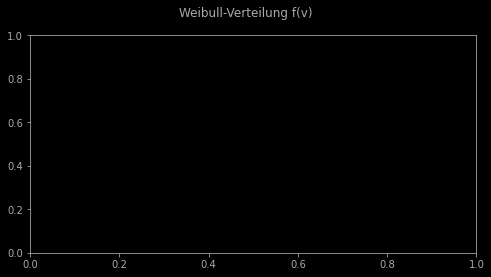

FloatSlider(value=2.0, description='k', max=3.0, min=1.0)

FloatSlider(value=6.0, description='A', max=20.0, min=1.0)

In [108]:
x = np.linspace(0,30,31)
fig, ax = plt.subplots(1, figsize=(8, 4))
plt.suptitle('Weibull-Verteilung f(v)')

def update_plot(k, A):
    
    """
    die Funtion plottet die Kurve erneut, wenn über
    die slider ein Wert geändert wird
    """
        
    # erstmal wieder die Zeichnung löschen
    ax.clear()
    
    # neuen Verlauf berechnen
    f_x = k/A*(x/A)**(k-1)*np.exp(-(x/A)**k)
    
    print(f_x)
    
    # und den neuen Verlauf plotten
    ax.plot(x, f_x, c='red')
    plt.show()
    
k = widgets.FloatSlider(min=1, max=3, value=2, description='k')
A = widgets.FloatSlider(min=1, max=20, value=6, description='A', position= 200)
   
# sobald einer der slider geändert wird, wird neu geplottet
widgets.interactive(update_plot, k=k, A=A)
display(k, A)

In [111]:
def f(n):
    plt.plot([0,1,2],[0,1,n])
    print("adf")
    plt.show()
widgets.interact(f,n=(0,10))

interactive(children=(IntSlider(value=5, description='n', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.f(n)>

In [ ]:
class B:
    def __init__(self):
        self.arr = np.zeros((3, 7))
        
    def update(self, i, x):
        self.arr[i] = np.copy(x)
        
    def to_dict(self):
        return {
            "arr": self.arr
        }
    
    
class Server:
    def __init__(self):
        self.b = B()
        
    def run(self):
        self.b.update(0, np.ones(7))
        
    def save(self):
        print(self.b.to_dict())

In [ ]:
server = Server()

In [ ]:
server.b.arr

In [ ]:
server.run()

In [ ]:
server.b.arr

In [ ]:
server.save()

In [ ]:
from time import sleep
import threading

In [ ]:
class Buf:
    def __init__(self):
        self.arr = np.zeros((3, 7))
        
    def update(self, i, x):
        self.arr[i] = np.copy(x)
        
    def to_dict(self):
        return {
            "arr": self.arr
        }
    
    
class Server(threading.Thread):
    def __init__(self):
        super(Server, self).__init__()
        self.b = Buf()
        
        self.stop = threading.Event()
        
    def run(self):
        self.stop.set()
        self.save()
        while self.stop.is_set():
            try:
                print("loop")
                self.b.update(0, np.random.random(7))
                sleep(2)
                self.save()
            except KeyboardInterrupt:
                print("keyboard interupt")
                self.save()
                self.stop.clear()
        
    def save(self):
        print(self.b.to_dict())
        
    def join(self):
        self.save()
        self.stop.clear()
        super().join()